In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import scprep

In [19]:
data = pd.read_csv("~/scratch60/single_trajectory.csv")
sling_pseudotime =  pd.read_csv("~/scratch60/single_trajectory_sling_pseudotime.csv").values.flatten()
actual_time = range(300)

In [3]:
data.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c291,c292,c293,c294,c295,c296,c297,c298,c299,c300
0,0.0,1.0,0.0,1.0,0.0,2.5,0.0,1.0,0.0,2,...,0.0,0.0,0,2.0,0.0,2,0.0,0.0,0,0.0
1,1.0,4.0,1.0,3.0,4.0,2.5,5.0,1.0,3.0,3,...,4.0,4.0,5,1.0,4.0,0,3.0,3.0,1,2.0
2,5.0,6.0,14.0,7.0,11.0,9.0,7.0,8.0,3.0,10,...,5.0,8.0,9,6.0,11.0,10,4.0,6.0,9,9.0
3,12.5,11.0,16.0,13.0,10.0,10.0,18.0,16.0,15.0,18,...,6.0,12.0,14,14.0,17.0,9,14.5,8.0,25,16.0
4,20.0,17.0,12.0,14.0,16.0,15.0,18.0,12.5,23.0,15,...,19.0,14.5,19,19.5,25.5,15,19.0,21.0,23,18.0


In [7]:
# pairwise distance
def compute_distances(X):
    '''
    Constructs a distance matrix from data set, assumes Euclidean distance

    Inputs:
        X       a numpy array of size n x p holding the data set (n observations, p features)

    Outputs:
        D       a numpy array of size n x n containing the euclidean distances between points

    '''
    
    # return distance matrix
    D = np.linalg.norm(X[:,:, np.newaxis] - X[:,:, np.newaxis].T, axis = 1)
    
    return D


def compute_affinity_matrix(D, kernel_type, sigma=None, k=None):
    '''
    Construct an affinity matrix from a distance matrix via gaussian kernel.

    Inputs:
        D               a numpy array of size n x n containing the distances between points
        kernel_type     a string, either "gaussian" or "adaptive".
                            If kernel_type = "gaussian", then sigma must be a positive number
                            If kernel_type = "adaptive", then k must be a positive integer
        sigma           the non-adaptive gaussian kernel parameter
        k               the adaptive kernel parameter

    Outputs:
        W       a numpy array of size n x n that is the affinity matrix

    '''

    # return the affinity matrix
    if kernel_type == "gaussian":
        if sigma is None:
            raise ValueError('sigma must be provided for gaussian kernel.')
        elif ((type(sigma) is not int) and (type(sigma) is not float)) or sigma <= 0:
            raise ValueError('sigma must be a positive number.')
            
        W = np.exp(- D ** 2 / (2 * sigma ** 2)) 
        
    elif kernel_type == "adaptive":
        if k is None:
            raise ValueError('k must be provided for adaptive gaussian kernel.')
        elif (type(k) is not int) or k <= 0:
            raise ValueError('k must be a positive integer.')
        # compute sigma 
        D_copy = D.copy()
        D_copy = D + np.diag(np.repeat(float("inf"), D.shape[0]))
        nn = D_copy.argsort(axis = 1)

        kth_idx = nn[:,k-1]
        kth_dist = D[range(D.shape[0]), kth_idx]
        s_i = np.tile(kth_dist[:,np.newaxis], (1, D.shape[0]))
        W = 1 / 2 * (np.exp(- D ** 2 / (s_i**2)) + np.exp(- D ** 2 / (s_i.transpose()**2)))

    else:
        raise ValueError('kernel_type must be either "gaussian" or "adaptive".')
        
    return W

In [8]:
euc_dist = compute_distances(data.values.T)
affinity = compute_affinity_matrix(euc_dist, kernel_type = "adaptive", k = 15)
W = affinity - np.eye(300)

row_sum = np.sum(W, axis = 1)
D_inv = np.diag(1/row_sum)
Ms = D_inv @ W

# eigendecomposition of Ms
lmbda, v = np.linalg.eig(Ms)

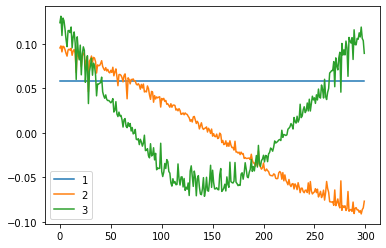

In [12]:
plt.plot(v[:,0], label = "1")
plt.plot(v[:,1], label = "2")
plt.plot(v[:,2], label = "3")
plt.legend()

In [14]:
scipy.stats.pearsonr(actual_time, v[:,1])

(-0.9936572761082583, 7.148787453085536e-285)

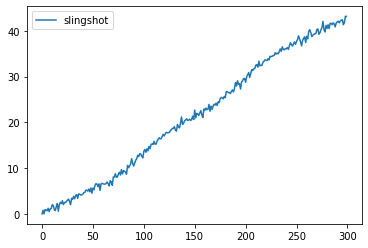

In [22]:
plt.plot(sling_pseudotime, label = "slingshot")
plt.legend()

In [21]:
scipy.stats.pearsonr(actual_time, sling_pseudotime)

(0.9972601055539106, 0.0)

slingshot pseudotime has better correlation with the actual time

## MST 

In [27]:
X = csr_matrix(euc_dist)
Tcsr = minimum_spanning_tree(X)

tcsr_arr = Tcsr.toarray() + Tcsr.toarray().T
tcsr_bool = tcsr_arr > 0

row_sum = np.sum(tcsr_arr, axis = 1)
D_inv = np.diag(1/row_sum)
Tcsr_norm = D_inv @ tcsr_arr

lmbda, v = np.linalg.eig(Tcsr_norm)
sorted_idx = np.argsort(lmbda)[::-1]

/home/mw957/project/conda_envs/r_env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


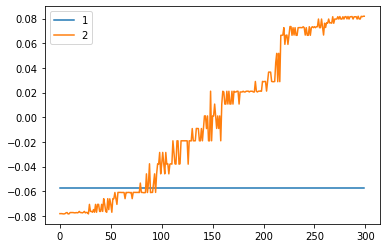

In [29]:
plt.plot(v[:,sorted_idx[0]], label = "1")
plt.plot(v[:,sorted_idx[1]], label = "2")
plt.legend()

In [30]:
scipy.stats.pearsonr(actual_time, v[:,sorted_idx[1]])

/home/mw957/project/conda_envs/r_env/lib/python3.7/site-packages/scipy/stats/stats.py:3446: ComplexWarning: Casting complex values to real discards the imaginary part
  prob = 2*special.btdtr(ab, ab, 0.5*(1 - abs(np.float64(r))))


((0.9840183184936174+0j), 2.2154973947389793e-225)

## MST using 1/similarity as the edge weight 

In [31]:
inv_sim = 1/affinity
X = csr_matrix(inv_sim)
Tcsr = minimum_spanning_tree(X)

tcsr_arr = Tcsr.toarray() + Tcsr.toarray().T
tcsr_bool = tcsr_arr > 0

row_sum = np.sum(tcsr_arr, axis = 1)
D_inv = np.diag(1/row_sum)
Tcsr_norm = D_inv @ tcsr_arr

lmbda, v = np.linalg.eig(Tcsr_norm)
sorted_idx = np.argsort(lmbda)[::-1]

/home/mw957/project/conda_envs/r_env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


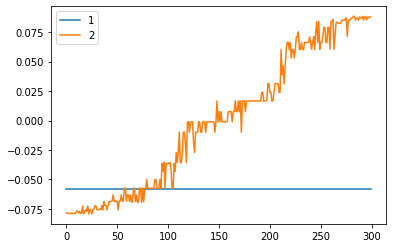

In [32]:
plt.plot(v[:,sorted_idx[0]], label = "1")
plt.plot(v[:,sorted_idx[1]], label = "2")
plt.legend()

In [33]:
scipy.stats.pearsonr(actual_time, v[:,sorted_idx[1]])

/home/mw957/project/conda_envs/r_env/lib/python3.7/site-packages/scipy/stats/stats.py:3446: ComplexWarning: Casting complex values to real discards the imaginary part
  prob = 2*special.btdtr(ab, ab, 0.5*(1 - abs(np.float64(r))))


((0.984636946611821+0j), 6.468135489299919e-228)

- 2nd eigenvector on MST has lower correlation with actual time compared with using the full graph. 
- higher correlation with actual time when using 1/similarity compared with Euclidean distance.

## Simulate single trajectory

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
x_early_deact = np.exp(np.arctan((np.arange(300, 0, -1) - 200)/50))
x_late_deact = np.exp(np.arctan((np.arange(300, 0, -1) - 100)/50))
x_early_act = np.exp(np.arctan((np.arange(1, 301) - 100)/50))
x_late_act = np.exp(np.arctan((np.arange(1, 301) - 200)/50))
x_transient = np.exp(np.arctan( np.hstack((np.arange(1, 101)/33, np.repeat(3,100), np.arange(100, 0, -1)/33))))

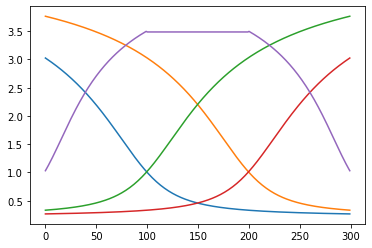

In [7]:
plt.plot(x_early_deact)
plt.plot(x_late_deact)
plt.plot(x_early_act)
plt.plot(x_late_act)
plt.plot(x_transient)

In [9]:
x_nonDE = np.repeat(np.array([0.1, 0.5, 1, 2, 3])[np.newaxis,], 300, axis = 0).T

means = np.vstack(
 (np.repeat(x_nonDE,100, axis = 0), # 500 non DE
  np.repeat(x_early_deact[np.newaxis,], 50, axis = 0), 
  np.repeat(x_late_deact[np.newaxis,], 50, axis = 0),
  np.repeat(x_early_act[np.newaxis,], 50, axis = 0), 
  np.repeat(x_late_act[np.newaxis,], 50, axis = 0),
  np.repeat(x_transient[np.newaxis,], 50, axis = 0)
 )
) # cells x gene

row_sum = np.apply_along_axis(sum, arr = means, axis = 1)
D_inv = np.diag(1/row_sum)
means_norm = D_inv @ means

mu = 7500
size = 4
p = size/(size + mu)
n = mu * p / (1 - p)

total_counts = np.random.negative_binomial(n = n, p = p, size = 750)

for i in range(1):
    total_c = total_counts[i]
    prob_vec = means_norm[i,:]
    gene_count = np.random.multinomial(n = total_c, pvals = prob_vec)

In [2]:
n_paths = 3
cells_per_path = 1000

# Splatter returns a `dict` objbect that contains a bunch of useful information
results = scprep.run.SplatSimulate(
                        method='paths', 
                        batch_cells=cells_per_path * n_paths, 
                        group_prob=np.tile(1/n_paths, n_paths), 
                        n_genes=5000,
                        de_down_prob=0.5,
                        path_from=[0,0,0],
                        mean_shape=1,
                        seed=0)

R[write to console]: Getting parameters...
R[write to console]: Creating simulation object...
R[write to console]: Simulating library sizes...
R[write to console]: Simulating gene means...
R[write to console]: Simulating path endpoints...
R[write to console]: Simulating path steps...
R[write to console]: Simulating BCV...
R[write to console]: Simulating counts...
R[write to console]: Simulating dropout (if needed)...
R[write to console]: Done!


In [3]:
# Put counts data in DataFrame
data = pd.DataFrame(results['counts'])

# Put metadata in a DataFrame
metadata = pd.DataFrame([results['step'], results['group']], index=['step', 'group']).transpose()
metadata = metadata.astype({'step': int}) # These are strings by default, but we want ints

# Adjusting the 'step' vector to monotonically increase
p1_mask = metadata['group'] == 1
metadata.loc[p1_mask, 'step'] = 100 - metadata.loc[p1_mask, 'step']
p23_mask = np.isin(metadata['group'], [2,3])
metadata.loc[p23_mask, 'step'] = 100 + metadata.loc[p23_mask, 'step']

# Change DataFrame index names to be a little nicer
new_index = pd.Index(['cell_{}'.format(i) for i in range(metadata.shape[0])])
data.index = new_index
metadata.index = new_index

# Library-size normalize and sqrt transform
data = scprep.normalize.library_size_normalize(data)
data = scprep.transform.sqrt(data)